# Heart Failure Predictions 

You are working for a hospital, and you are asked to build a model to predict whether a patient is going to have a heart failure or not. You are given a dataset with 11 features, and a target. 

You need to:
- Carry out an EDA
- Build pipelines to preprocess the data
- Test the following models using your previously built pipelines : 
    - logistic reg, 
    - KNN, 
    - SVC
- Choose a performance metric and compare models
- Perform feature selection to improve your score
- Tune your models (using regulatisation and grid/random search)
- Finally, export your model into a pickle

As you know, the ML modeling is an iterative process. We give you the big steps but it is up to you to follow an iterative process to clean data, test models and build new pipelines until you find your best model.

Remember, you have only one day to do this task. Go fast to find a baseline model with dummy assumptions. Then, improve the modeling iteratively. 

Data Information: 
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [100]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve,precision_recall_curve

from sklearn.model_selection import learning_curve

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.inspection import permutation_importance
from itertools import combinations
import pickle
import joblib

In [52]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Load the dataset

In [53]:
df = pd.read_csv('heart_data.csv')

In [54]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [55]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

# Dictionnaires de données

<ul>
    <li><b>Age :</b> L'âge du patient en années.</li>
    <li><b>Sex :</b> Le sexe du patient. Typiquement codé comme 'M' pour masculin et 'F' pour féminin.</li>
    <ul>
            <li>0 : Femme.</li>
            <li>1 : Homme.</li>
        </ul>
    <li><b>ChestPainType :</b> Type de douleur thoracique. Voici les types courants :
        <ul>
            <li>TA (Typical Angina) : Angine typique.</li>
            <li>ATA (Atypical Angina) : Angine atypique.</li>
            <li>NAP (Non-Anginal Pain) : Douleur non angineuse.</li>
            <li>ASY (Asymptomatic) : Asymptomatique.</li>
        </ul>
    </li>
    <li><b>RestingBP :</b> La pression artérielle au repos (en mm Hg).</li>
    <li><b>Cholesterol :</b> Le taux de cholestérol sérique (en mg/dL).</li>
    <li><b>FastingBS :</b> Le taux de sucre dans le sang après un jeûne. Typiquement, c'est une valeur binaire :
        <ul>
            <li>0 : Si la glycémie à jeun est inférieure à 120 mg/dL.</li>
            <li>1 : Si la glycémie à jeun est supérieure ou égale à 120 mg/dL.</li>
        </ul>
    </li>
    <li><b>RestingECG :</b> Les résultats de l'électrocardiogramme (ECG) au repos. Les valeurs possibles incluent :
        <ul>
            <li>Normal : Résultat normal.</li>
            <li>ST : Présence d'anomalies de segment ST-T (inversion de l'onde T et/ou élévation ou dépression de ST > 0,05 mV).</li>
            <li>LVH : Hypertrophie ventriculaire gauche probable ou certaine d'après les critères d'Estes.</li>
        </ul>
    </li>
    <li><b>MaxHR :</b> La fréquence cardiaque maximale atteinte pendant l'exercice (en bpm).</li>
    <li><b>ExerciseAngina :</b> Angine de poitrine induite par l'exercice. C'est généralement codé comme :
        <ul>
            <li>Y : Oui (présence d'angine de poitrine pendant l'exercice).</li>
            <li>N : Non (absence d'angine de poitrine pendant l'exercice).</li>
        </ul>
    </li>
    <li><b>Oldpeak :</b> Dépression du segment ST induite par l'exercice par rapport au repos (en mm). Cela mesure une sorte de déviation de l'ECG.</li>
    <li><b>ST_Slope :</b> La pente du segment ST pendant l'exercice. Les valeurs typiques sont :
        <ul>
            <li>Up : Montée (ST en hausse).</li>
            <li>Flat : Plate (ST plat).</li>
            <li>Down : Descente (ST en baisse).</li>
        </ul>
    </li>
    <li><b>HeartDisease :</b> Présence d'une maladie cardiaque. Typiquement codé comme :
        <ul>
            <li>1 : Présence d'une maladie cardiaque.</li>
            <li>0 : Absence d'une maladie cardiaque.</li>
        </ul>
    </li>
</ul>


# EDA

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [57]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [58]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [59]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
913    False
914    False
915    False
916    False
917    False
Length: 918, dtype: bool

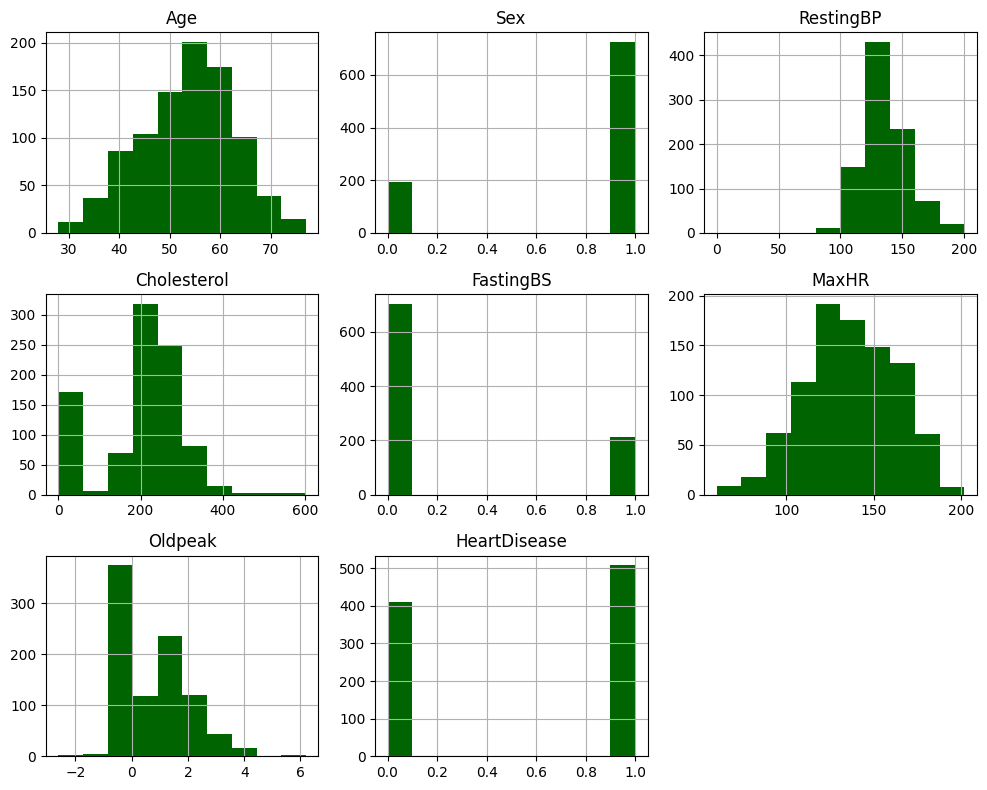

In [97]:
df.hist(figsize=(10, 8), color='#006400')
plt.tight_layout()
plt.show()

In [61]:
df_encoded = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

corr_matrix = df_encoded.corr()

target_correlation = corr_matrix['HeartDisease'].sort_values(ascending=False)

HeartDisease = target_correlation.to_frame(name='HeartDisease')

HeartDisease

,HeartDisease
HeartDisease,1.000000
ST_Slope_Flat,0.554134
ChestPainType_ASY,0.516716
ExerciseAngina_Y,0.494282
Oldpeak,0.403951
Sex_M,0.305445
Age,0.282039
FastingBS,0.267291
ST_Slope_Down,0.122527
RestingBP,0.107589


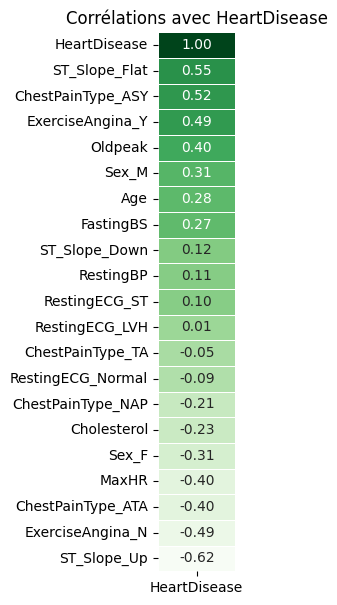

In [62]:
plt.figure(figsize=(1, 7))
sns.heatmap(HeartDisease, annot=True, cmap='Greens', fmt='.2f', linewidths=0.5, cbar=False)
plt.title('Corrélations avec HeartDisease')
plt.show()

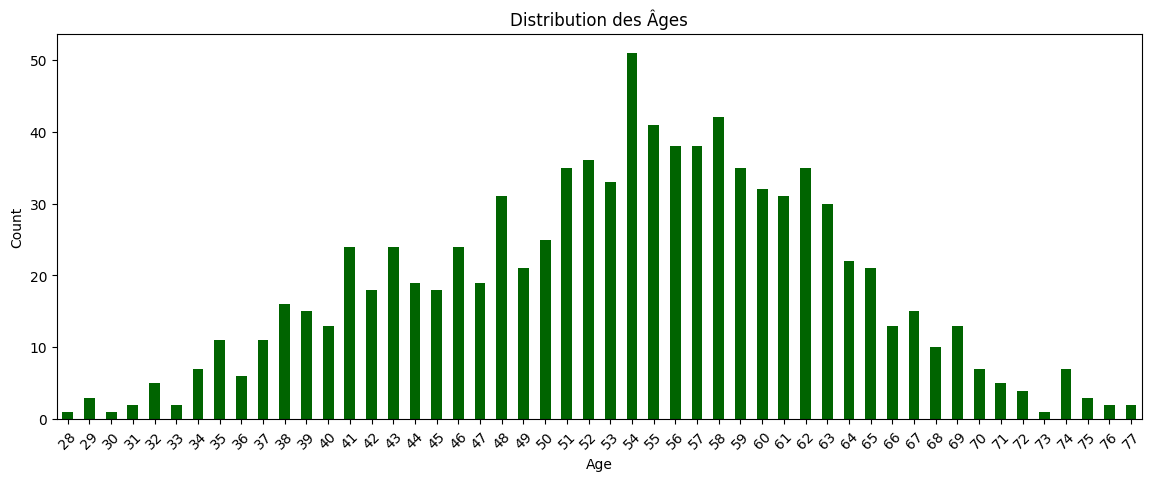

In [63]:
HeartDisease_df = df.sort_values(by='Age')

age_distribution = HeartDisease_df["Age"].value_counts().sort_index()

age_distribution.plot(kind='bar', figsize=(14, 5), color="#006400")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Distribution des Âges")
plt.show()

In [64]:
unique_values = df['ChestPainType'].unique()
print(unique_values)

['ATA' 'NAP' 'ASY' 'TA']


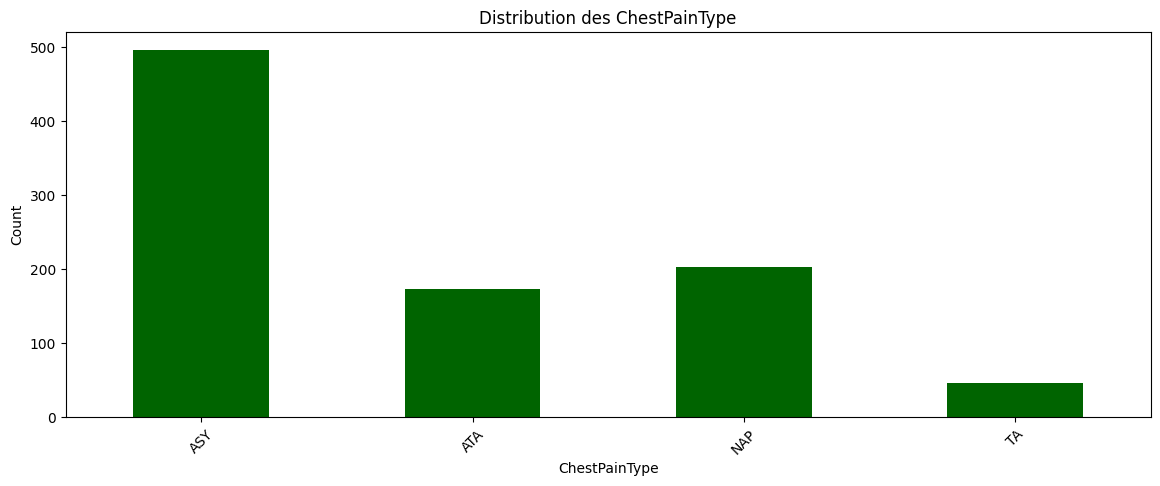

In [65]:
HeartDisease_df = df.sort_values(by='ChestPainType')

age_distribution = HeartDisease_df["ChestPainType"].value_counts().sort_index()

age_distribution.plot(kind='bar', figsize=(14, 5), color="#006400")
plt.xlabel("ChestPainType")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Distribution des ChestPainType")
plt.show()

In [66]:
unique_values = df['RestingECG'].unique()
print(unique_values)

['Normal' 'ST' 'LVH']


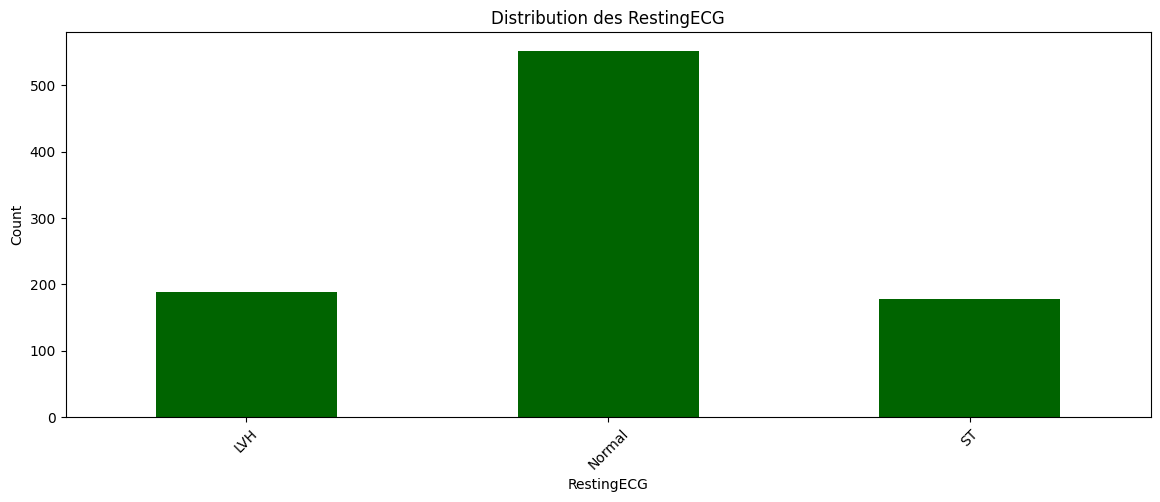

In [67]:
HeartDisease_df = df.sort_values(by='RestingECG')

age_distribution = HeartDisease_df["RestingECG"].value_counts().sort_index()

age_distribution.plot(kind='bar', figsize=(14, 5), color="#006400")
plt.xlabel("RestingECG")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Distribution des RestingECG")
plt.show()

In [68]:
unique_values = df['ExerciseAngina'].unique()
print(unique_values)

['N' 'Y']


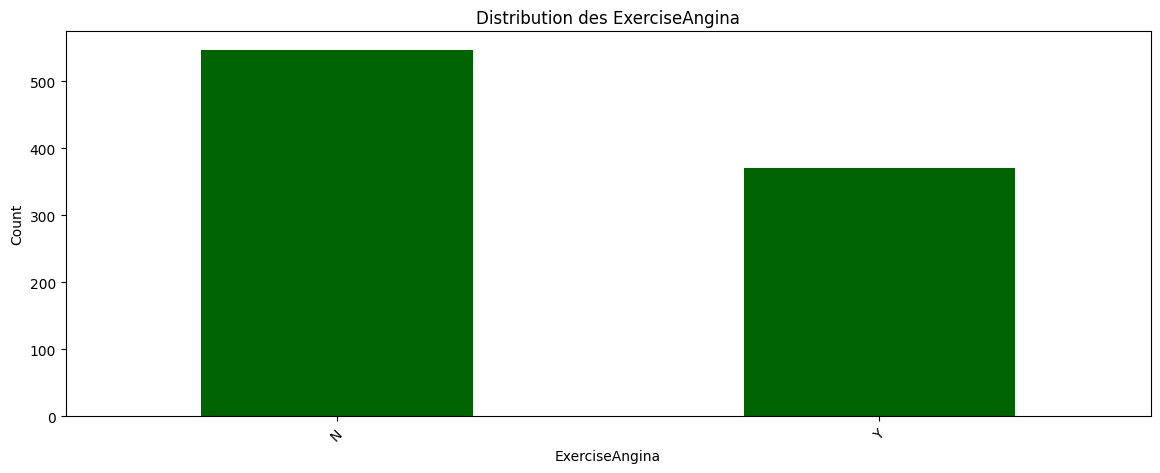

In [69]:
HeartDisease_df = df.sort_values(by='ExerciseAngina')

age_distribution = HeartDisease_df["ExerciseAngina"].value_counts().sort_index()

age_distribution.plot(kind='bar', figsize=(14, 5), color="#006400")
plt.xlabel("ExerciseAngina")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Distribution des ExerciseAngina")
plt.show()

In [70]:
unique_values = df['ST_Slope'].unique()
print(unique_values)

['Up' 'Flat' 'Down']


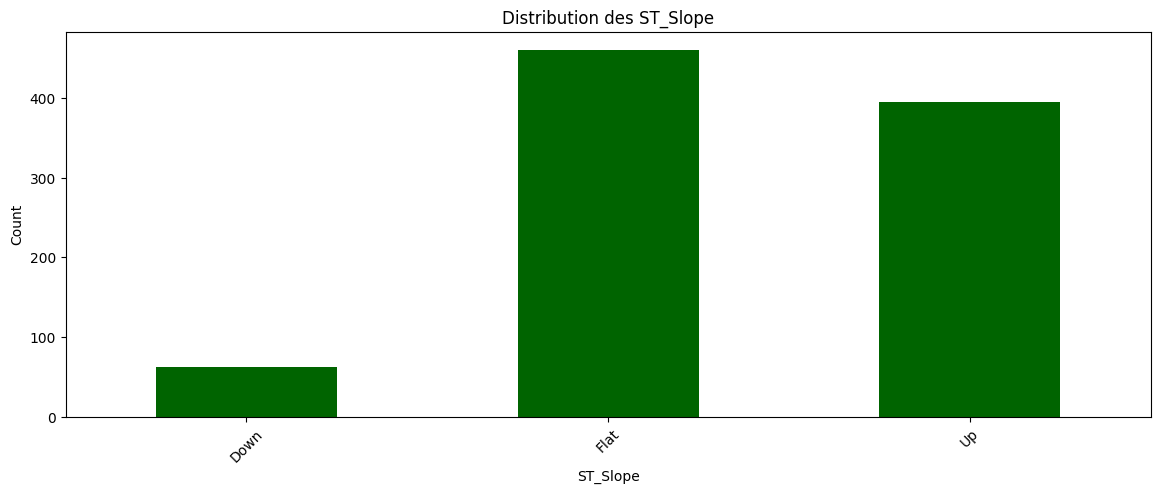

In [71]:
HeartDisease_df = df.sort_values(by='ST_Slope')

age_distribution = HeartDisease_df["ST_Slope"].value_counts().sort_index()

age_distribution.plot(kind='bar', figsize=(14, 5), color="#006400")
plt.xlabel("ST_Slope")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Distribution des ST_Slope")
plt.show()

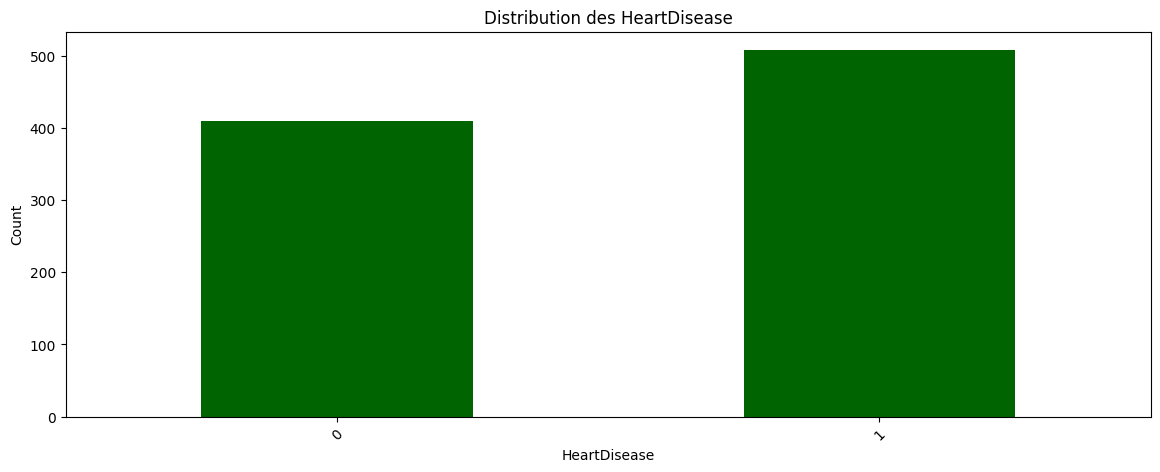

In [72]:
HeartDisease_df = df.sort_values(by='HeartDisease')

age_distribution = HeartDisease_df["HeartDisease"].value_counts().sort_index()

age_distribution.plot(kind='bar', figsize=(14, 5), color="#006400")
plt.xlabel("HeartDisease")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Distribution des HeartDisease")
plt.show()

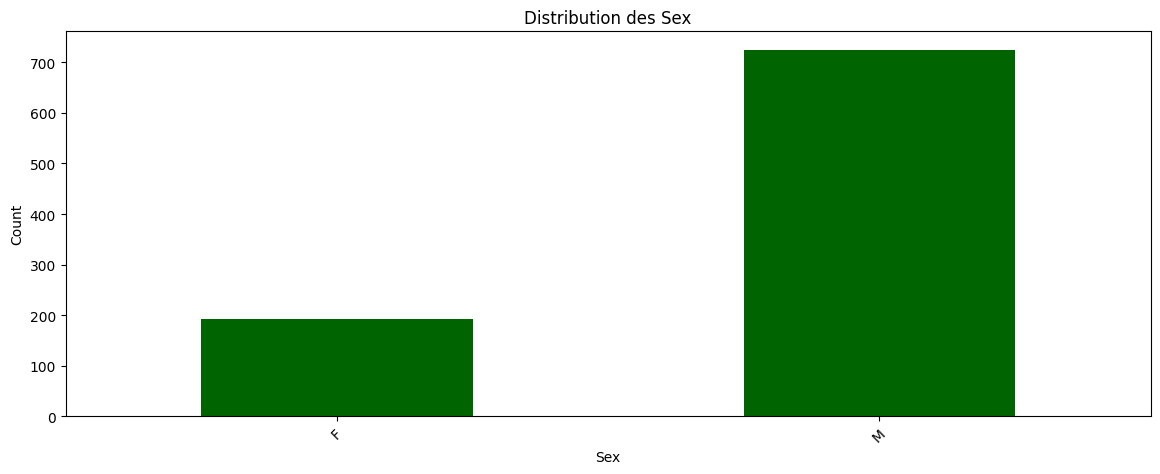

In [73]:
HeartDisease_df = df.sort_values(by='Sex')

age_distribution = HeartDisease_df["Sex"].value_counts().sort_index()

age_distribution.plot(kind='bar', figsize=(14, 5), color="#006400")
plt.xlabel("Sex")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Distribution des Sex")
plt.show()

In [74]:
# La data est clean, pas de doublon ni de valeurs manquantes. 918 lignes pour 12 colonnes.
# Corrélation notable avec ChestPainType, ExerciseAngina, Oldpeak, Sex, Age,
# FastingBS, Cholesterol, MaxHR, ST_Slope - > on peux en déduire que ce sont nos features potentielles

In [75]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [76]:
columns = list(df.columns)
columns

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

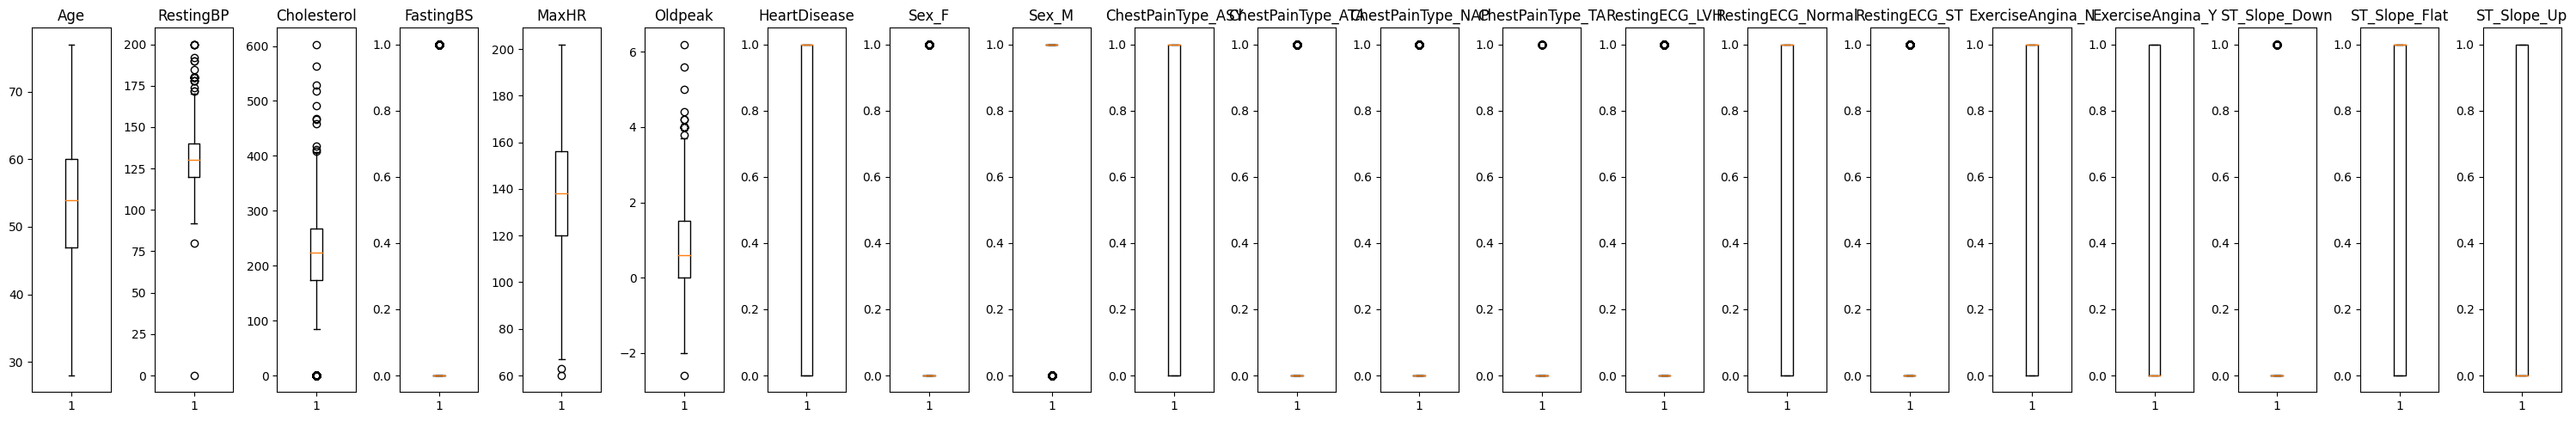

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=len(df_encoded.columns), figsize=(30, 5))

# Boucle sur les colonnes du DataFrame
for i, column in enumerate(df_encoded.columns):
    axes[i].boxplot(df_encoded[column])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [78]:
# On constate la présence d'Outliers sur certaines colonnes qu'il faudra traiter

In [79]:
label_encoder = LabelEncoder()

df['Sex'] = label_encoder.fit_transform(df['Sex'])

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [80]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

# Preprocessing

In [81]:
X = df[['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']]
y = df["HeartDisease"]

#Je sépare mes données de test et d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Je stipule mes données
numeric_features = ['Sex', 'Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Pipeline de transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Pipeline de preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipelines

In [82]:
#Pipeline de modèle + preprocessing
Logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Entraînement du modèle
Logistic.fit(X_train, y_train)

# Prdiction
predictions = Logistic.predict(X_test)

# Métrique
accuracy = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(conf_matrix)
print(class_report)

Accuracy: 0.8533
[[67 10]
 [17 90]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



In [83]:
#Pipeline de modèle + preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Prdiction
predictions = pipeline.predict(X_test)

# Métrique
accuracy = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(conf_matrix)
print(class_report)

Accuracy: 0.8750
[[67 10]
 [13 94]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



In [84]:
#Pipeline de modèle + preprocessing
SVC = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Entraînement du modèle
SVC.fit(X_train, y_train)

# Prdiction
predictions = SVC.predict(X_test)

# Métrique
accuracy = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(conf_matrix)
print(class_report)

Accuracy: 0.8750
[[65 12]
 [11 96]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        77
           1       0.89      0.90      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



# Model Selection

In [85]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Sex', 'Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier', KNeighborsClassifier())])

In [86]:
# On prend le KNN car il à une bonne accuracy et c'est celui qui dispose du plus faible chiffre en Faux Negatif et également en 
# Faux Positif

# Performance Evaluation

In [87]:
#Accuracy: 0.8750
#Faux Neg. = 10
#Faux Pos. = 13

In [88]:
cross_val = cross_val_score(pipeline, X, y, error_score='raise')
print(cross_val)
cross_val.mean()

[0.84782609 0.88043478 0.83695652 0.81420765 0.75956284]


0.8277975766215253

# Feature Selection

In [89]:
df.select_dtypes(include=['number']).columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'Oldpeak', 'HeartDisease'],
      dtype='object')

In [90]:
X = add_constant(df[['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       feature         VIF
0        const  148.292054
1          Age    1.315644
2          Sex    1.081205
3    RestingBP    1.102640
4  Cholesterol    1.183764
5    FastingBS    1.117389
6        MaxHR    1.263889
7      Oldpeak    1.107560


In [91]:
X = df[['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
        'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']]
y = df["HeartDisease"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = KNeighborsClassifier(n_neighbors=5)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_base)
print(f"Exactitude du modèle de base : {base_accuracy}")

best_features = None
best_accuracy = 0.0

for r in range(1, len(X.columns) + 1):
    for combo in combinations(X.columns, r):
        selected_features = list(combo)
        
        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X_train[selected_features], y_train)
        
        y_pred = model.predict(X_test[selected_features])
        accuracy = accuracy_score(y_test, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = selected_features

# Affichage des résultats
print(f"Meilleures caractéristiques : {best_features}")
print(f"Exactitude avec meilleures caractéristiques : {best_accuracy}")

Exactitude du modèle de base : 0.7065217391304348
Meilleures caractéristiques : ['Sex', 'FastingBS', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'ST_Slope_Flat']
Exactitude avec meilleures caractéristiques : 0.8804347826086957


In [92]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()

for i in sorted_idx:
    print(f"{X.columns[i]} : {result.importances_mean[i]:.4f} +/- {result.importances_std[i]:.4f}")

Sex : 0.0000 +/- 0.0000
FastingBS : 0.0000 +/- 0.0000
ChestPainType_NAP : 0.0000 +/- 0.0000
ChestPainType_TA : 0.0000 +/- 0.0000
RestingECG_ST : 0.0000 +/- 0.0000
ST_Slope_Flat : 0.0000 +/- 0.0000
ST_Slope_Up : 0.0000 +/- 0.0000
ChestPainType_ATA : 0.0005 +/- 0.0016
RestingECG_Normal : 0.0027 +/- 0.0027
ExerciseAngina_Y : 0.0027 +/- 0.0027
Oldpeak : 0.0076 +/- 0.0055
Age : 0.0342 +/- 0.0174
RestingBP : 0.0380 +/- 0.0190
Cholesterol : 0.1120 +/- 0.0170
MaxHR : 0.1147 +/- 0.0379


# Model Tuning

In [93]:
# Features et target
X = df[['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
        'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']]
y = df["HeartDisease"]

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définition des transformations pour les colonnes numériques et catégorielles
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Préprocesseur des colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Création du pipeline complet avec préprocesseur et KNeighborsClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
predictions = pipeline.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(conf_matrix)
print(class_report)

# Définition des paramètres à tester dans la grille de recherche
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],          # Nombre de voisins
    'classifier__weights': ['uniform', 'distance'],      # Méthode de pondération des voisins
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithme de calcul
    'classifier__leaf_size': [10, 20, 30, 40],            # Taille de la feuille pour ball_tree ou kd_tree
    'classifier__metric': ['euclidean', 'manhattan'],    # Méthode de calcul de la distance
}

# Initialisation de GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Exécution de la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
print("Meilleur score de validation croisée : ", grid_search.best_score_)

Accuracy: 0.8859
[[68  9]
 [12 95]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        77
           1       0.91      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Meilleurs paramètres trouvés :  {'classifier__algorithm': 'auto', 'classifier__leaf_size': 10, 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Meilleur score de validation croisée :  0.8800857329233065


In [94]:
# Évaluation du meilleur modèle sur l'ensemble de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Précision sur l'ensemble de test : ", test_accuracy)

Précision sur l'ensemble de test :  0.8804347826086957


In [95]:
tuned_knn_pipe = grid_search.best_estimator_
cross_val_score(tuned_knn_pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8800857329233065

# Export you model

In [98]:
with open("tuned_knn_pipeline.pkl", "wb") as file:
    pickle.dump(tuned_knn_pipe, file)

# Load pipeline from pickle file
my_pipeline = pickle.load(open("tuned_knn_pipeline.pkl","rb"))

my_pipeline.score(X_test, y_test)

0.8804347826086957

In [101]:
# Chemin vers le fichier de sauvegarde
filename = 'model.joblib'

# Sauvegarder le pipeline
joblib.dump(pipeline, filename)

['model.joblib']